# Ejercicio de Regresión 1 (Core)

Objetivo

 Aplicar los conceptos de regresión lineal para resolver un problema práctico utilizando Python.

 Descripción del problema: Supongamos que trabajas en una empresa que desea predecir el precio de venta de casas en función de varias características. Tienes un conjunto de datos con información sobre las casas, incluyendo el tamaño de la casa (en pies cuadrados), el número de habitaciones, el número de baños y la antigüedad de la casa (en años). Tu tarea es construir un modelo de regresión lineal que pueda predecir el precio de venta de una casa dada.

Instrucciones:

1. Carga de datos: Descarga el archivo de datos house_prices.csv que contiene las siguientes columnas:
* SqFt: Tamaño de la casa en pies cuadrados.
* Bedrooms: Número de habitaciones.
* Bathrooms: Número de baños.
* price: Precio de venta de la casa.
2. Exploración de datos: Realiza un análisis exploratorio de los datos para entender su estructura y detectar posibles problemas como valores nulos o outliers.
3. Preparación de datos: Divide los datos en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%).
4. Entrenamiento del modelo: Entrena un modelo de regresión lineal utilizando los datos de entrenamiento.
5. Evaluación del modelo: Evalúa el modelo utilizando el conjunto de prueba. Calcula el error cuadrático medio (MSE) y el R-cuadrado (R²) del modelo.
6. Predicción: Usa el modelo entrenado para predecir el precio de una casa con las siguientes características:
* Tamaño: 2000 pies cuadrados
* Habitaciones: 3
* Baños: 2

### EDA

#### Librerias y Dataset

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

data=pd.read_csv('../Data/house_prices.csv')

#### Consistencia en tipos de datos

Convertimos todas las columnas en sus respectivos dtypes

In [54]:
data_dict = {
    'Home': 'int64',
    'Price': 'float64',
    'SqFt': 'float64',
    'Bedrooms': 'int64',
    'Bathrooms': 'int64',
    'Offers': 'int64',
    'Brick': 'bool',
    'Neighborhood': 'category'
    
}

# Convertir tipos de datos según el diccionario
for column, dtype in data_dict.items():
    data[column] = data[column].astype(dtype, errors='ignore')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Home          128 non-null    int64   
 1   Price         128 non-null    float64 
 2   SqFt          128 non-null    float64 
 3   Bedrooms      128 non-null    int64   
 4   Bathrooms     128 non-null    int64   
 5   Offers        128 non-null    int64   
 6   Brick         128 non-null    bool    
 7   Neighborhood  128 non-null    category
dtypes: bool(1), category(1), float64(2), int64(4)
memory usage: 6.5 KB


Identificamos inconsistencias en valores categoricos

In [55]:
# Identificar columnas de tipo 'object', típicamente usadas para variables categóricas
categorical_columns = data.select_dtypes(include=['category','bool']).columns
# Crear un diccionario donde cada clave es el nombre de la columna y los valores son los valores únicos de esa columna
unique_values_dict = {col: data[col].unique() for col in categorical_columns}
# Convertir el diccionario en un DataFrame, rellenando con NaN cuando haya menos valores únicos
unique_values_df = pd.DataFrame.from_dict(unique_values_dict, orient='index').transpose()
# Mostrar el DataFrame resultante
unique_values_df.T

,0,1,2
Brick,True,None,None
Neighborhood,East,North,West


#### Limpieza de datos

Realizamos histogramas para conocer sus distribuciones de las columnas Price y SqFt que son las variables numericas

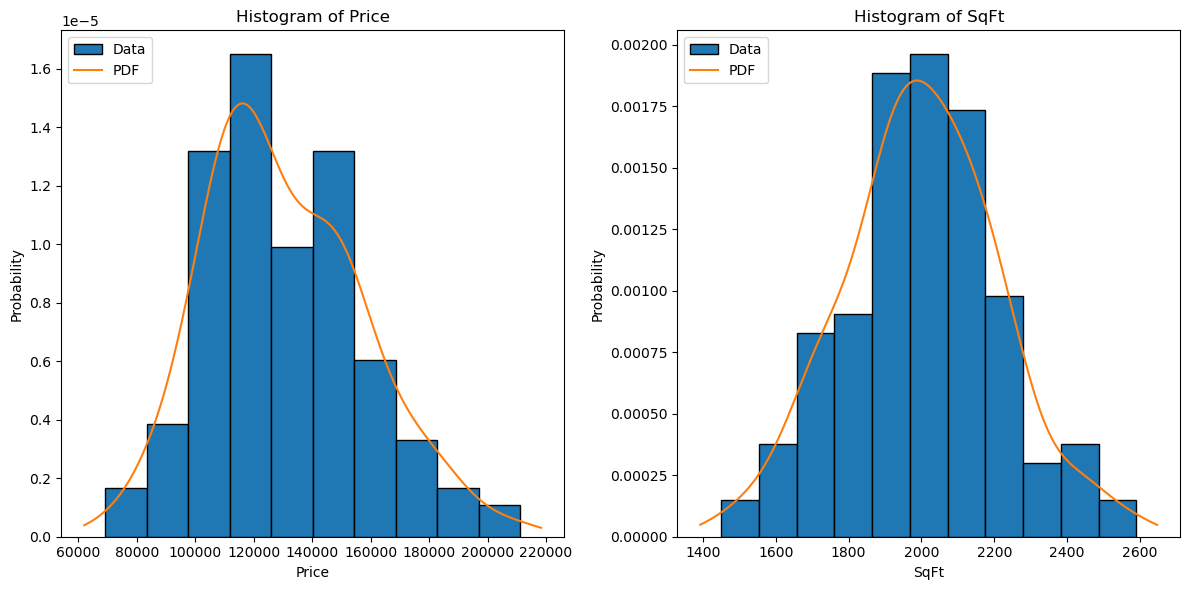

In [56]:
def plot_histogram_kde(data, ax, label):
    # Calcular los bins de Freedman-Diaconis
    q25, q75 = np.percentile(data, [25, 75])
    bin_width = 2 * (q75 - q25) * len(data) ** (-1/3)
    bins = round((data.max() - data.min()) / bin_width)
    
    # Graficar histograma y KDE
    ax.hist(data, density=True, bins=bins, label="Data", edgecolor='black')
    mn, mx = ax.get_xlim()
    kde_xs = np.linspace(mn, mx, 300)
    kde = st.gaussian_kde(data)
    ax.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    ax.set_ylabel("Probability")
    ax.set_xlabel(label)
    ax.set_title(f"Histogram of {label}")
    ax.legend(loc="upper left")

# Crear la figura y los subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráficos para 'Price' y 'SqFt'
plot_histogram_kde(data['Price'], axes[0], 'Price')
plot_histogram_kde(data['SqFt'], axes[1], 'SqFt')

plt.tight_layout()
plt.show()


Creamos boxplots para identificar Outliers

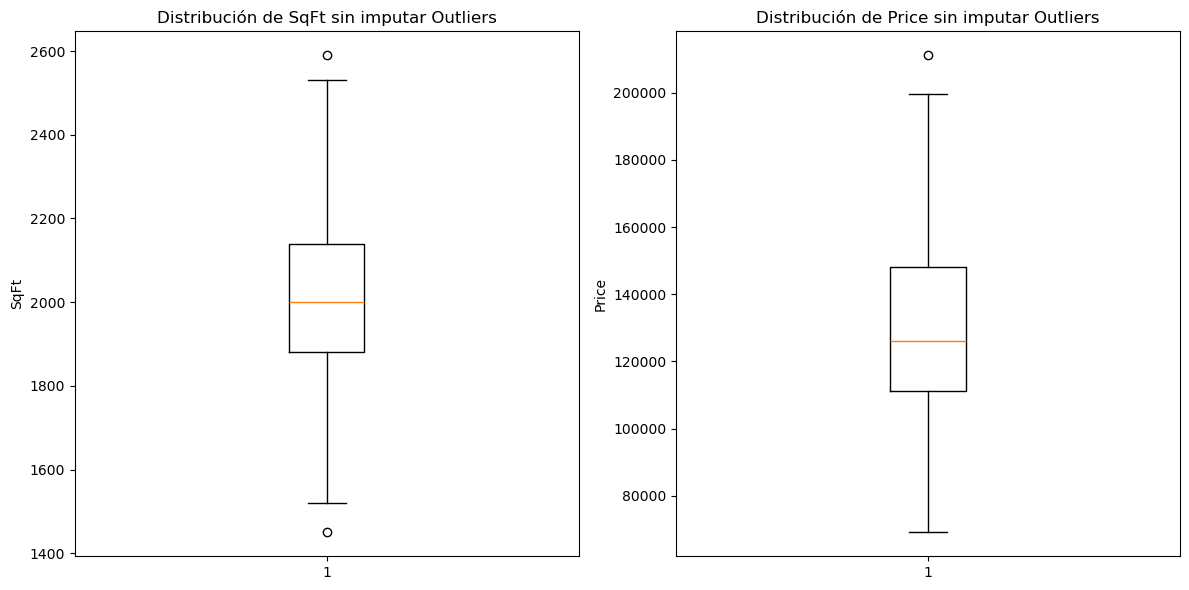

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Primer gráfico: Boxplot de 'SqFt'
axes[0].boxplot(data['SqFt'])
axes[0].set_title('Distribución de SqFt sin imputar Outliers')
axes[0].set_ylabel('SqFt')

# Segundo gráfico: Boxplot de 'Price'
axes[1].boxplot(data['Price'])
axes[1].set_title('Distribución de Price sin imputar Outliers')
axes[1].set_ylabel('Price')

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

Calculamos el rango IQR para poder imputar valores Outliers en un nuevo dataframe

In [58]:
cols = ['Price', 'SqFt']  # one or more

Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
IQR = Q3 - Q1

#Creamos un nuevo dataframe para no modificar el original
data_imputed = data.copy()

mean_price = data['Price'].mean()
data_imputed.loc[(data_imputed['Price'] < (Q1['Price'] - 1.5 * IQR['Price'])) | (data_imputed['Price'] > (Q3['Price'] + 1.5 * IQR['Price'])), 'Price'] = int(mean_price)

mean_sqft = data['SqFt'].mean()
data_imputed.loc[(data_imputed['SqFt'] < (Q1['SqFt'] - 1.5 * IQR['SqFt'])) | (data_imputed['SqFt'] > (Q3['SqFt'] + 1.5 * IQR['SqFt'])), 'SqFt'] = int(mean_sqft)


Graficamos histogramas del nuevo dataframe

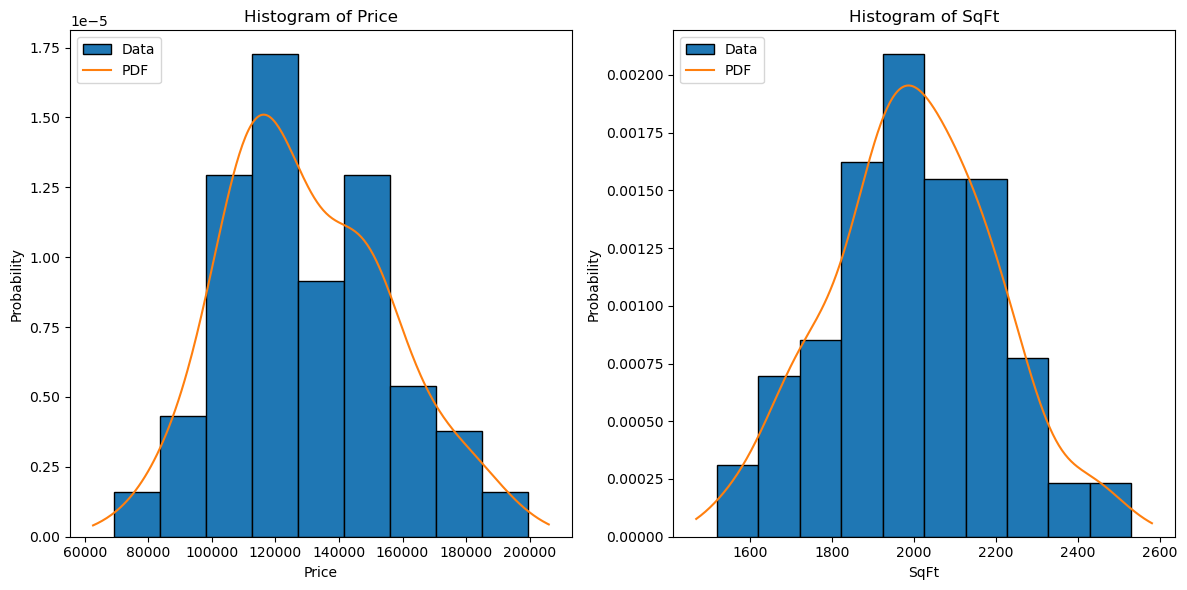

In [59]:
def plot_histogram_kde(data_imputed, ax, label):
    # Calcular los bins de Freedman-Diaconis
    q25, q75 = np.percentile(data_imputed, [25, 75])
    bin_width = 2 * (q75 - q25) * len(data_imputed) ** (-1/3)
    bins = round((data_imputed.max() - data_imputed.min()) / bin_width)
    
    # Graficar histograma y KDE
    ax.hist(data_imputed, density=True, bins=bins, label="Data", edgecolor='black')
    mn, mx = ax.get_xlim()
    kde_xs = np.linspace(mn, mx, 300)
    kde = st.gaussian_kde(data_imputed)
    ax.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
    ax.set_ylabel("Probability")
    ax.set_xlabel(label)
    ax.set_title(f"Histogram of {label}")
    ax.legend(loc="upper left")

# Crear la figura y los subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráficos para 'Price' y 'SqFt'
plot_histogram_kde(data_imputed['Price'], axes[0], 'Price')
plot_histogram_kde(data_imputed['SqFt'], axes[1], 'SqFt')

plt.tight_layout()
plt.show()

Vemos los boxplots para poder ver si se eliminaron algunos Outliers

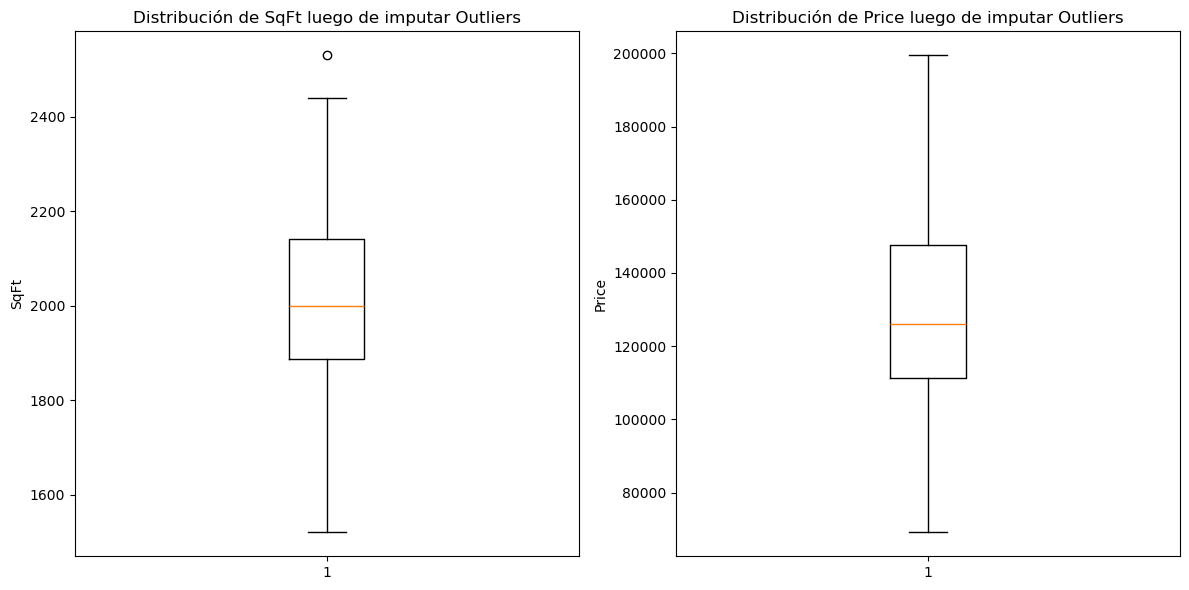

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Primer gráfico: Boxplot de 'SqFt'
axes[0].boxplot(data_imputed['SqFt'])
axes[0].set_title('Distribución de SqFt luego de imputar Outliers')
axes[0].set_ylabel('SqFt')

# Segundo gráfico: Boxplot de 'Price'
axes[1].boxplot(data_imputed['Price'])
axes[1].set_title('Distribución de Price luego de imputar Outliers')
axes[1].set_ylabel('Price')

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

### Model

In [61]:
data2=pd.read_csv('../Data/house_prices.csv')
data_dict = {
    'Home': 'int64',
    'Price': 'float64',
    'SqFt': 'float64',
    'Bedrooms': 'int64',
    'Bathrooms': 'int64',
    'Offers': 'int64',
    'Brick': 'bool',
    'Neighborhood': 'category'
    
}

# Convertir tipos de datos según el diccionario
for column, dtype in data_dict.items():
    data2[column] = data2[column].astype(dtype, errors='ignore')
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Home          128 non-null    int64   
 1   Price         128 non-null    float64 
 2   SqFt          128 non-null    float64 
 3   Bedrooms      128 non-null    int64   
 4   Bathrooms     128 non-null    int64   
 5   Offers        128 non-null    int64   
 6   Brick         128 non-null    bool    
 7   Neighborhood  128 non-null    category
dtypes: bool(1), category(1), float64(2), int64(4)
memory usage: 6.5 KB


In [62]:


# Separar características y etiquetas
X = data2.drop(columns=['Price'])
y = data2['Price']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0, shuffle=True
)

# Definir transformaciones
numeric_features = X.select_dtypes(include=['float64', 'int']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Reemplazar NaN por 0
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['category', 'bool']).columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear pipeline completo incluyendo el modelo
pipeline_completo = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entrenar el pipeline completo
pipeline_completo.fit(X_train, y_train)

# Realizar predicciones
y_pred = pipeline_completo.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Error Cuadrático Medio: {mse}')
print(f'R-cuadrado: {r2}')

Error Cuadrático Medio: 128470631.49614345
R-cuadrado: 0.8016320187403977


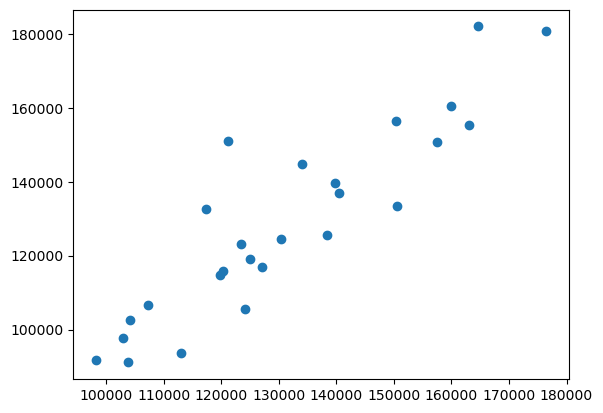

In [63]:
plt.figure()
#linea de tendencia
plt.scatter(y_pred,y_test)

In [64]:
pipeline_completo

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Brick', 'Neighborhood'], dtype='object'))])),
                ('regressor', LinearRegression())])

#### Hacemos la prediccion para calcular el precio para un nuevo dato

In [65]:
new_data = pd.DataFrame([[
    1,              # Home (int64)
    2000,           # SqFt (float64)
    3,              # Bedrooms (int64)
    2,              # Bathrooms (int64)
    1,              # Offers (int64)
    True,           # Brick (bool)
    'North'         # Neighborhood (category)
]], columns=['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers', 'Brick', 'Neighborhood'])

# Asegurarte de que los tipos de datos sean correctos
new_data['Neighborhood'] = new_data['Neighborhood'].astype('category')
new_data['Brick'] = new_data['Brick'].astype('bool')


new_data['Home'] = new_data['Home'].astype('int64')
new_data['SqFt'] = new_data['SqFt'].astype('float64')
new_data['Bedrooms'] = new_data['Bedrooms'].astype('int64')
new_data['Bathrooms'] = new_data['Bathrooms'].astype('int64')
new_data['Offers'] = new_data['Offers'].astype('int64')

# Hacer la predicción
prediction = pipeline_completo.predict(new_data)

print(f'Predicción del precio: ${prediction[0]:,.2f}')

Predicción del precio: $131,875.59


#### Entrenamiento de 3 modelos a la vez

In [66]:
data_imputed

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300.0,1790.0,2,2,2,True,East
1,2,114200.0,2030.0,4,2,3,True,East
2,3,114800.0,1740.0,3,2,1,True,East
3,4,94700.0,1980.0,3,2,3,True,East
4,5,119800.0,2130.0,3,3,3,True,East
...,...,...,...,...,...,...,...,...
123,124,119700.0,1900.0,3,3,3,True,East
124,125,147900.0,2160.0,4,3,3,True,East
125,126,113500.0,2070.0,2,2,2,True,North
126,127,149900.0,2020.0,3,3,1,True,West


In [67]:
data_imputed=pd.read_csv('../Data/house_prices.csv')
data_dict = {
    'Home': 'float64',
    'Price': 'float64',
    'SqFt': 'float64',
    'Bedrooms': 'float64',
    'Bathrooms': 'float64',
    'Offers': 'float64',
    'Brick': 'category',
    'Neighborhood': 'category'
    
}

# Convertir tipos de datos según el diccionario
for column, dtype in data_dict.items():
    data_imputed[column] = data_imputed[column].astype(dtype, errors='ignore')
data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Home          128 non-null    float64 
 1   Price         128 non-null    float64 
 2   SqFt          128 non-null    float64 
 3   Bedrooms      128 non-null    float64 
 4   Bathrooms     128 non-null    float64 
 5   Offers        128 non-null    float64 
 6   Brick         128 non-null    category
 7   Neighborhood  128 non-null    category
dtypes: category(2), float64(6)
memory usage: 6.6 KB


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


In [69]:
numeric_features = data_imputed.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data_imputed.select_dtypes(include=['object', 'category', 'bool']).columns

print("Columnas numéricas:", list(numeric_features))
print("Columnas categóricas:", list(categorical_features))

Columnas numéricas: ['Home', 'Price', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers']
Columnas categóricas: ['Brick', 'Neighborhood']


In [70]:
# 1. Primero, verifica las columnas de tu dataset
print("Columnas en el dataset:")
print(data_imputed.columns)

# 2. Separar features (X) y target (y)
X = data_imputed.drop('Price', axis=1)  # Todas las columnas excepto el target
y = data_imputed['Price']  # Tu variable objetivo

# 3. Definir columnas numéricas y categóricas
# IMPORTANTE: No incluir 'Price' en numeric_features ya que es el target
numeric_features = ['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers']  # Quité 'Price'
categorical_features = ['Brick', 'Neighborhood']

# Verifica que las columnas existan
print("\nVerificando columnas:")
print("Columnas numéricas en el dataset:", 
      [col for col in numeric_features if col in X.columns])
print("Columnas categóricas en el dataset:", 
      [col for col in categorical_features if col in X.columns])

# 4. Actualizar las listas solo con las columnas que existen
numeric_features = [col for col in numeric_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

Columnas en el dataset:
Index(['Home', 'Price', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers', 'Brick',
       'Neighborhood'],
      dtype='object')

Verificando columnas:
Columnas numéricas en el dataset: ['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers']
Columnas categóricas en el dataset: ['Brick', 'Neighborhood']


In [ ]:
# 2. Separar features (X) y target (y)
# Ajusta estas líneas según tus columnas
X = data_imputed.drop('Price', axis=1)  # Todas las columnas excepto el target
y = data_imputed['Price']  # Tu variable objetivo

# 3. Definir columnas numéricas y categóricas
# Ajusta estas listas según tus columnas
numeric_features = ['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers']
categorical_features = ['Brick', 'Neighborhood']


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Cambiado a median para mejor manejo de outliers
    ('scaler', StandardScaler())  # Cambiado a StandardScaler que suele funcionar mejor
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Crear el preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Esto manejará cualquier columna no especificada
)

# Crear pipelines para diferentes modelos
models = {
    'Linear Regression': Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    'Random Forest': Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))]),
    'KNN': Pipeline([('preprocessor', preprocessor), ('regressor', KNeighborsRegressor(n_neighbors=3))])
}

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Entrenar y evaluar modelos
results = {}
for name, pipe in models.items():
    try:
        pipe.fit(X_train, y_train)  # Entrenamos todo el pipeline
        y_pred = pipe.predict(X_test)  # Hacemos las predicciones
        mse = mean_squared_error(y_test, y_pred)  # Calculamos el MSE
        r2 = r2_score(y_test, y_pred)  # Calculamos el R²
        results[name] = {'MSE': mse, 'R2': r2}
        print(f"{name} - MSE: {mse:.4f}, R²: {r2:.4f}")
    except Exception as e:
        print(f"Error en {name}: {str(e)}")


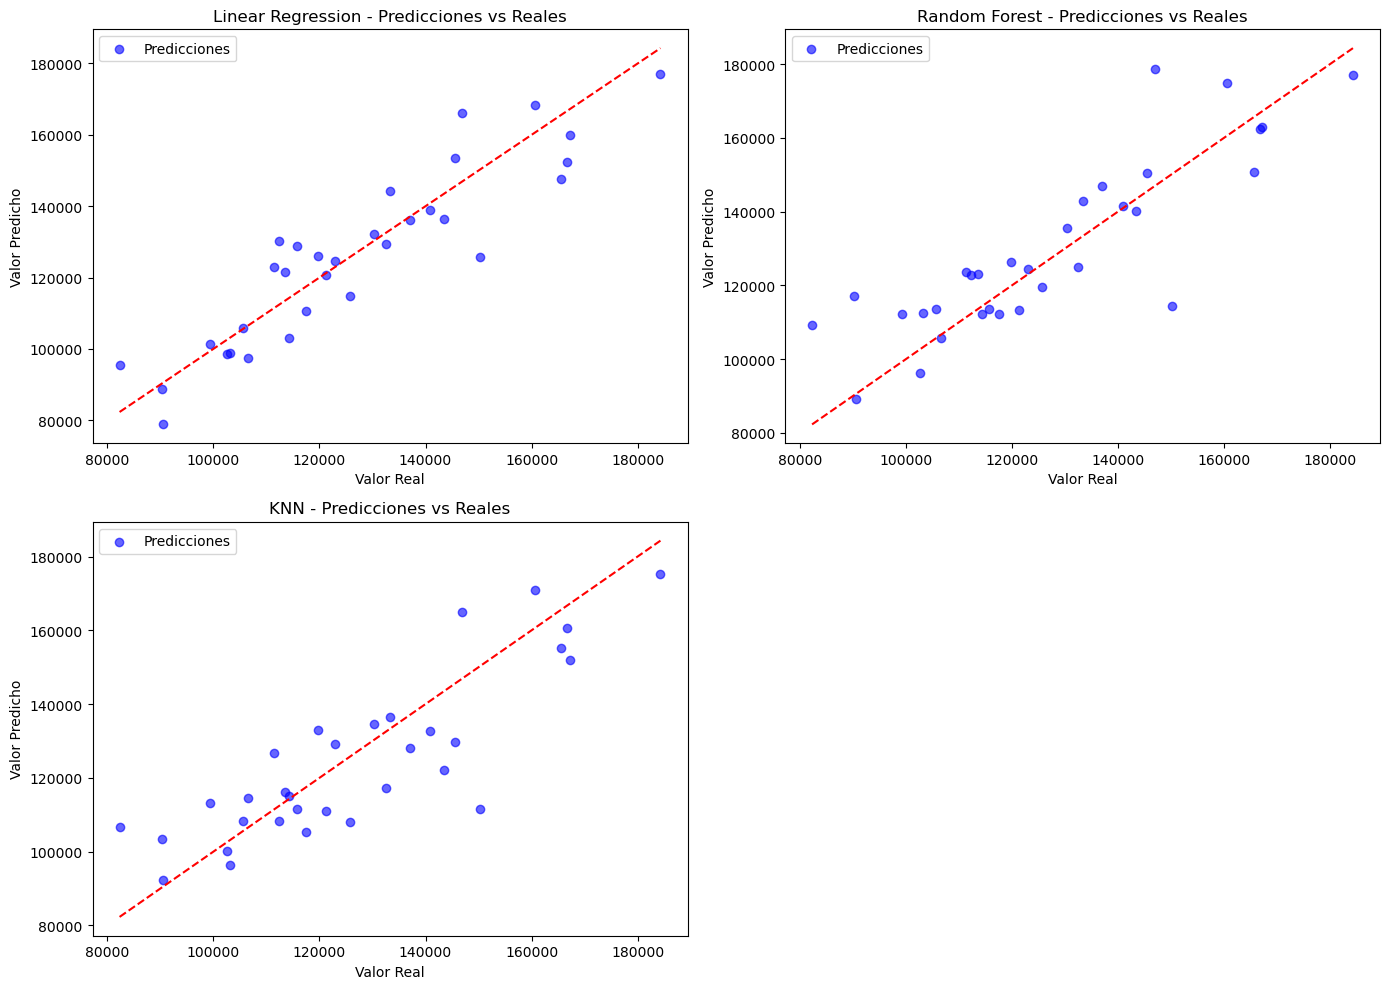

In [ ]:
import matplotlib.pyplot as plt

# Crear la figura
plt.figure(figsize=(14, 10))

# Graficar cada modelo
for i, (name, pipe) in enumerate(models.items(), start=1):
    try:
        # Hacer las predicciones
        y_pred = pipe.predict(X_test)
        
        # Crear un subgráfico para cada modelo
        plt.subplot(2, 2, i)
        
        # Graficar los valores reales vs los valores predichos
        plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predicciones')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea de referencia
        plt.title(f'{name} - Predicciones vs Reales')
        plt.xlabel('Valor Real')
        plt.ylabel('Valor Predicho')
        plt.legend()
        
    except Exception as e:
        print(f"Error en {name}: {str(e)}")

# Ajustar el layout
plt.tight_layout()
plt.show()


In [ ]:
# Verificar que no hay problemas con los datos
print("\nInformación de X:")
print(X.dtypes)
print("\nValores únicos en columnas categóricas:")
for col in categorical_features:
    print(f"\n{col}:", X[col].unique())


Información de X:
Home             float64
SqFt             float64
Bedrooms         float64
Bathrooms        float64
Offers           float64
Brick           category
Neighborhood    category
dtype: object

Valores únicos en columnas categóricas:

Brick: ['No', 'Yes']
Categories (2, object): ['No', 'Yes']

Neighborhood: ['East', 'North', 'West']
Categories (3, object): ['East', 'North', 'West']


In [ ]:
# Inspeccionar tipos de datos
print("Tipos de datos en X:")
print(X.dtypes)

# Ver valores únicos en cada columna
for column in X.columns:
    print(f"\nValores únicos en {column}:")
    print(X[column].unique())

Tipos de datos en X:
Home             float64
SqFt             float64
Bedrooms         float64
Bathrooms        float64
Offers           float64
Brick           category
Neighborhood    category
dtype: object

Valores únicos en Home:
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128.]

Valores únicos en SqFt:
[1790. 2030. 1740. 1980. 2130. 1780. 1830. 2160. 2110. 1730. 1870. 1910.
 2150. 2590. 219